In [1]:
import numpy as np
import random
from PIL import Image
import time
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pandas as pd
import re
import seaborn as sns
from sklearn import linear_model
import warnings
warnings.simplefilter("ignore")

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# function to determine new location by random walk
def walk_random(i, j, a_l, remove_step=None):
    temp_walk_steps = [(0,1), (0,-1), (1,0), (-1,0)]
    if i == 0:
        temp_walk_steps.remove((-1,0))
    if i == a_l-1:
        temp_walk_steps.remove((1,0))
    if j == 0:
        temp_walk_steps.remove((0,-1))
    if j == a_l-1:
        temp_walk_steps.remove((0,1))
    if remove_step in temp_walk_steps:
        temp_walk_steps.remove(remove_step)
    step = random.choice(temp_walk_steps)
    i, j = i+step[0], j+step[1]
    return i, j, step
            
# function to generate or simulate DLA
# inputs:
#       a_l  : image size ( array_length )
#       N : Number of points
#       k : stickiness 
def generate_dla(a_l, N, k):
    s_m = np.zeros((a_l, a_l))
    mid=(a_l-1)//2
    s_m[mid][mid] = 1
    random.seed()
    for n in range(N-1):
        #print(n)
        r=random.randint(0, 4*a_l-1)
        if r//a_l < 2:
            i = (r//a_l)*(a_l-1)
            j = r%a_l
        else:
            i = r%a_l
            j = (r//a_l-2)*(a_l-1)
        stop = 0
        step = (0,0)
        while stop==0:
            if s_m[i][j] ==1:
                if step == (0,0):
                    i, j, step = walk_random(i, j, a_l, remove_step=step)
                else:
                    i, j = i-step[0], j-step[1]
                    p=random.random()
                    if p < k:
                        s_m[i][j] = 1
                        stop = 1
                    else:
                        i, j, step = walk_random(i, j, a_l, remove_step=step)
            else:
                i, j, step = walk_random(i, j, a_l, remove_step=None)
                
                    
    image = Image.fromarray(s_m*255)
    image = image.convert("L")
    filename='image_'+str(a_l)+'_'+str(N)+str('_')+str(k)+str('_.png')
    image.save(filename)
    imshow(s_m*255)

In [3]:
# Generate all the dla data

#[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#for k in [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
#    print("new k: "+str(k))
#    generate_dla(501, 20000, k)

# defineing a bounding box for each image minX, maxX, minY, maxY
# bound density = area of bounding box / Number of points


# Convolution density : kernal of size 3*3
# Move the kernal 
# neighborhood density = Sum of all  neighborhood density when value = 1
# surface area = area around the points

In [4]:
#assumed no points on the edges for simplicity 
def dla_properties(s_m):
    kernal_size = 3
    N = np.count_nonzero(s_m)
    array_length = s_m.shape[0]
    bound_xmin = s_m.nonzero()[0].min()
    bound_xmax = s_m.nonzero()[0].max()
    bound_ymin = s_m.nonzero()[1].min()
    bound_ymax = s_m.nonzero()[1].max()
    bound_density = (bound_xmax+1-bound_xmin)*(bound_ymax+1-bound_ymin)/N
    kernal = np.array([[0,1,0],[1,0,1], [0, 1, 0]])
    neighborhood_density = 0
    surface_area = 0
    n_k = array_length-kernal_size +1
    for j in range(n_k):
        for i in range(n_k):
            if s_m[i+1][j+1] ==1:
                neighborhood_density += 9-s_m[i:i+kernal_size, j:j+kernal_size].sum()
                surface_area += 4-np.multiply(s_m[i:i+kernal_size, j:j+kernal_size], kernal).sum()
    
    return array_length, N, bound_density, neighborhood_density, surface_area

In [5]:
image_files = glob.glob("images/*.png")
dff = pd.DataFrame(columns=['Array_length', 'Points', 'bound_density', 'neighborhood_density', 'surface_area', 'stickiness'])
i=0
for f in image_files:
    s_m = np.array(Image.open(f))/255
    k = re.split('_', f)[-2]
    #print(k)
    prop =list(dla_properties(s_m))
    prop.append(float(k))
    #print(prop)
    dff.loc[i]=prop
    i += 1

# Analysis for stickiness between [0.1, 1]

[25001.0, 15000.0, 10000.0, 20000.0]


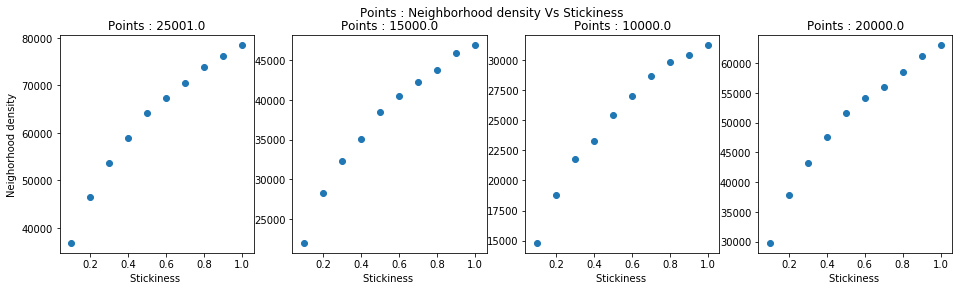

In [6]:
df=dff.loc[dff['stickiness']>0.05,:]
N= df['Points'].nunique()
plt.rcParams['figure.figsize'] = 16, 4
points = list(df['Points'].unique())
print(points)
fig, axs = plt.subplots(1, N, sharey=False, squeeze=True)
fig.suptitle("Points : Neighborhood density Vs Stickiness")
axs[0].set_ylabel("Neighorhood density")
for i,n in enumerate(points):
    df1=df.loc[df["Points"]==n,:]
    ax1=axs[i].scatter(np.array(df1['stickiness']), np.array(df1['neighborhood_density']))
    axs[i].set_title("Points : "+str(n))
    axs[i].set_xlabel('Stickiness ')
plt.show()
    

[25001.0, 15000.0, 10000.0, 20000.0]


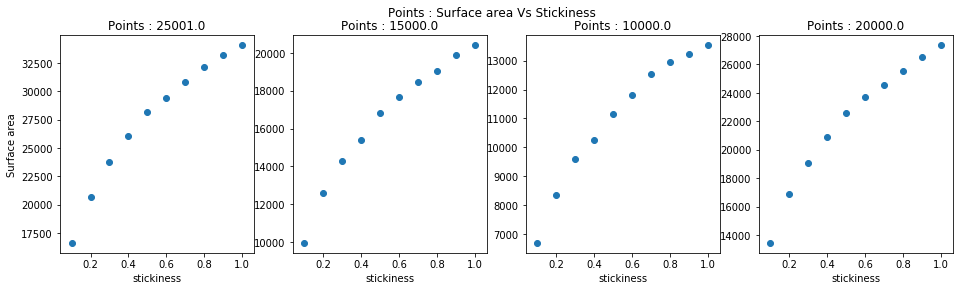

In [7]:
N= df['Points'].nunique()
plt.rcParams['figure.figsize'] = 16, 4
points = list(df['Points'].unique())
print(points)
fig, axs = plt.subplots(1, N, sharey=False, squeeze=True)
fig.suptitle("Points : Surface area Vs Stickiness")
axs[0].set_ylabel("Surface area")
for i,n in enumerate(points):
    df1=df.loc[df["Points"]==n,:]
    ax1=axs[i].scatter(np.array(df1['stickiness']), np.array(df1['surface_area']))
    axs[i].set_title("Points : "+str(n))
    axs[i].set_xlabel('stickiness')
plt.show()

[25001.0, 15000.0, 10000.0, 20000.0]


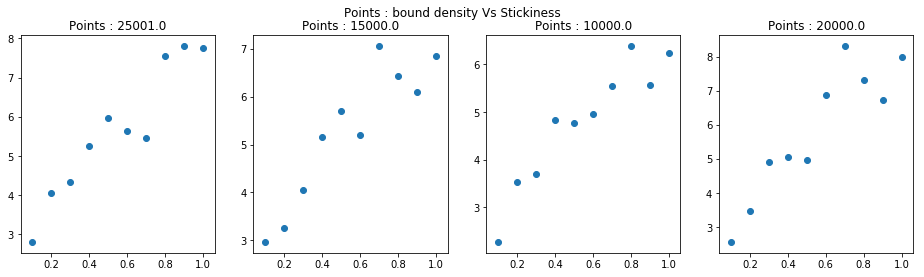

In [8]:
N= df['Points'].nunique()
plt.rcParams['figure.figsize'] = 16, 4
points = list(df['Points'].unique())
print(points)
fig, axs = plt.subplots(1, N, sharey=False, squeeze=True)
fig.suptitle("Points : bound density Vs Stickiness")

for i,n in enumerate(points):
    df1=df.loc[df["Points"]==n,:]
    ax1=axs[i].scatter(np.array(df1['stickiness']), np.array(df1['bound_density']))
    axs[i].set_title("Points : "+str(n))
    #axs.suptitle('Points : '+str(n))
plt.show()

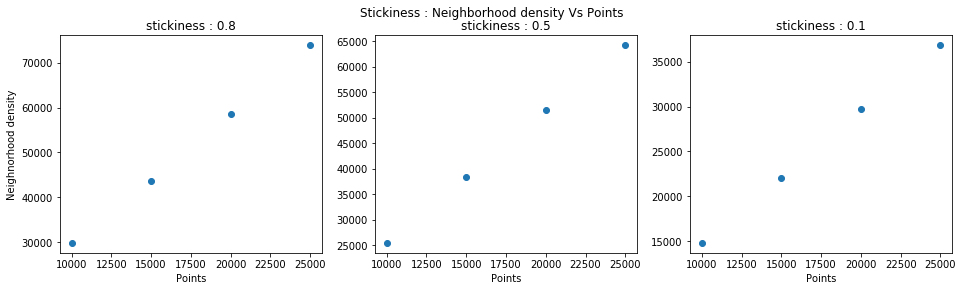

In [9]:
plt.rcParams['figure.figsize'] = 16, 4
k_values = [0.8, 0.5, 0.1]
fig, axs = plt.subplots(1, 3, sharey=False, squeeze=True)
fig.suptitle("Stickiness : Neighborhood density Vs Points")
axs[0].set_ylabel('Neighnorhood density')
for i,k in enumerate(k_values):
    df1=df.loc[df["stickiness"]==k,:]
    ax1=axs[i].scatter(np.array(df1['Points']), np.array(df1['neighborhood_density']))
    axs[i].set_title("stickiness : "+str(k))
    axs[i].set_xlabel('Points')
    #axs.suptitle('Points : '+str(n))
plt.show()

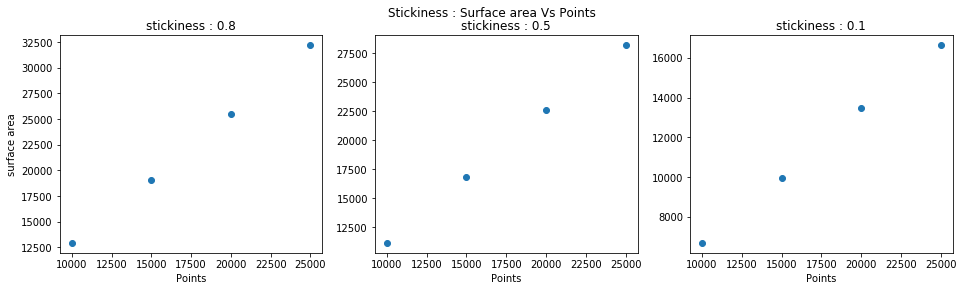

In [10]:
plt.rcParams['figure.figsize'] = 16, 4
k_values = [0.8, 0.5, 0.1]
fig, axs = plt.subplots(1, 3, sharey=False, squeeze=True)
fig.suptitle("Stickiness : Surface area Vs Points")
axs[0].set_ylabel('surface area')
for i,k in enumerate(k_values):
    df1=df.loc[df["stickiness"]==k,:]
    ax1=axs[i].scatter(np.array(df1['Points']), np.array(df1['surface_area']))
    axs[i].set_title("stickiness : "+str(k))
    axs[i].set_xlabel('Points')
    #axs.suptitle('Points : '+str(n))
plt.show()

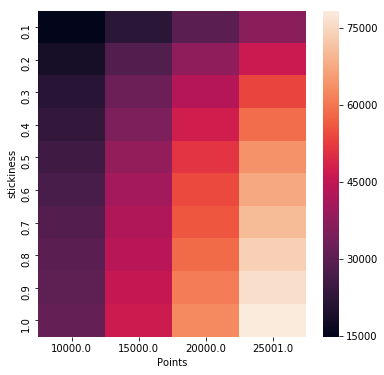

In [11]:
df1=df.loc[df['stickiness']>=0.1,:]
df1=df1.loc[df1['Points'].isin([10000,15000, 20000, 25001]),:]
df1=df1.pivot("stickiness", "Points", "neighborhood_density")
plt.rcParams['figure.figsize'] = 6, 6
ax=sns.heatmap(df1)

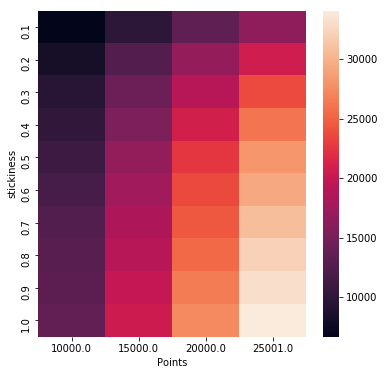

In [12]:
df1=df.loc[df['stickiness']>=0.1,:]
df1=df1.loc[df1['Points'].isin([10000,15000, 20000, 25001]),:]
df1=df1.pivot("stickiness", "Points", "surface_area")
plt.rcParams['figure.figsize'] = 6, 6
ax=sns.heatmap(df1)

In [13]:
# for given stickiness, surface area is linearly related to Number of points
# trying to find relation between surface area / Num of points
df['S/N']=df['surface_area']/df['Points']
df['ND/N']=df['neighborhood_density']/df['Points']

In [14]:
df.loc[df['stickiness']==0.8]

,Array_length,Points,bound_density,neighborhood_density,surface_area,stickiness,S/N,ND/N
14,501.0,15000.0,6.422533,43724.0,19060.0,0.8,1.270667,2.914933
25,501.0,10000.0,6.384000,29850.0,12944.0,0.8,1.294400,2.985000
32,501.0,20000.0,7.315300,58590.0,25512.0,0.8,1.275600,2.929500
38,501.0,25001.0,7.545058,73890.0,32180.0,0.8,1.287149,2.955482


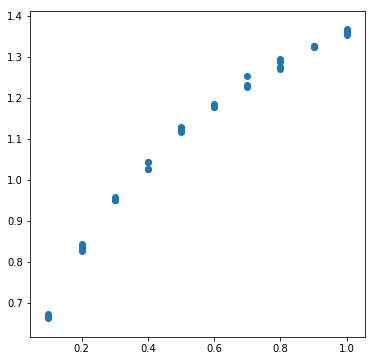

In [15]:
plt.scatter(df['stickiness'], df['S/N'])

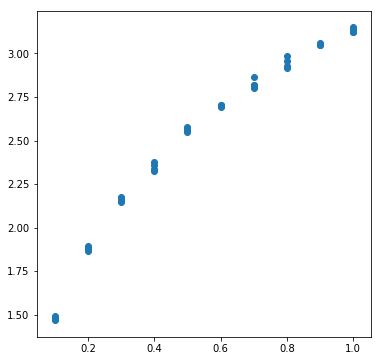

In [16]:
plt.scatter(df['stickiness'], df['ND/N'])

In [17]:
# As per stickness vs S/N plot show k is polynomial fit to surface area for given number of points
x=np.array(df['S/N'])
y=np.array(df['stickiness'])
pred_obj_sa = np.poly1d(np.polyfit(x, y, 3))
s=list(map(lambda i: pred_obj_sa(i), list(x)))

# validation on same data set
print("Mean Absolute % Error for Polynomial Fit of Surface area : ")
print(np.absolute(np.divide(y-np.array(s), y)).sum()/len(s))

Mean Absolute % Error for Polynomial Fit of Surface area : 
0.017255818346533842


In [18]:
# As per stickness vs ND/N plot show k is polynomial fit to surface area for given number of points
x=np.array(df['ND/N'])
y=np.array(df['stickiness'])
pred_obj_nd = np.poly1d(np.polyfit(x, y, 3))
s=list(map(lambda i: pred_obj_nd(i), list(x)))

# validation on same data set
print("Mean Absolute % Error for Polynomial Fit of Neighborhood density : ")
print(np.absolute(np.divide(y-np.array(s), y)).sum()/len(s))

Mean Absolute % Error for Polynomial Fit of Neighborhood density : 
0.018164724584711724


In [19]:
image_files = glob.glob("test_images/*.png")
dff_test = pd.DataFrame(columns=['Array_length', 'Points', 'bound_density', 'neighborhood_density', 'surface_area', 'stickiness'])
i=0
for f in image_files:
    s_m = np.array(Image.open(f))/255
    k = re.split('_', f)[-2]
    #print(k)
    prop =list(dla_properties(s_m))
    prop.append(float(k))
    #print(prop)
    dff_test.loc[i]=prop
    i += 1

In [20]:
df_test = dff_test.loc[dff_test['stickiness']>0.05,:]
df_test['S/N']=df_test['surface_area']/df_test['Points']
df_test['ND/N']=df_test['neighborhood_density']/df_test['Points']
x_test_sa=np.array(df_test['S/N'])
x_test_nd=np.array(df_test['ND/N'])
y=np.array(df_test['stickiness'])
k_sa = list(map(lambda i: pred_obj_sa(i), list(x_test_sa)))
k_nd = list(map(lambda i: pred_obj_nd(i), list(x_test_nd)))
print("Mean Absolute % Error for Polynomial Fit using Surface Area: ")
print(np.absolute(np.divide(y-np.array(k_sa), y)).sum()/len(df_test))
print("Mean Absolute % Error for Polynomial Fit using neighborhood density : ")
print(np.absolute(np.divide(y-np.array(k_nd), y)).sum()/len(df_test))

Mean Absolute % Error for Polynomial Fit using Surface Area: 
0.026007468940849036
Mean Absolute % Error for Polynomial Fit using neighborhood density : 
0.0255865415067242


# Analysis for stickiness between [0.001, 0.05]

In [21]:
dff1=dff.loc[dff['stickiness']<0.1,:]
dff1['S/N']=dff1['surface_area']/dff1['Points']
dff1['ND/N']=dff1['neighborhood_density']/dff1['Points']
dff1['ratio']=dff1['S/N']/(dff1['S/N']+dff1['bound_density'])

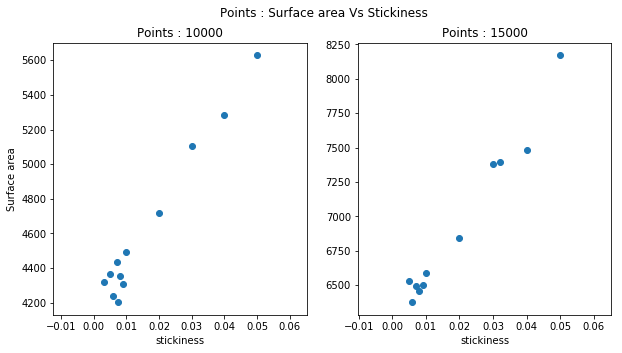

In [22]:
plt.rcParams['figure.figsize'] = 10, 5
points = [10000, 15000]
fig, axs = plt.subplots(1, 2, sharey=False, squeeze=True)
fig.suptitle("Points : Surface area Vs Stickiness")
axs[0].set_ylabel("Surface area")
for i,n in enumerate(points):
    df1=dff1.loc[dff1["Points"]==n,:]
    ax1=axs[i].scatter(np.array(df1['stickiness']), np.array(df1['surface_area']))
    axs[i].set_title("Points : "+str(n))
    axs[i].set_xlabel('stickiness')
plt.show()

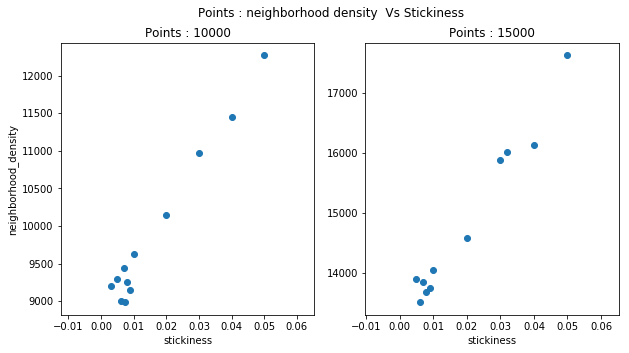

In [23]:
plt.rcParams['figure.figsize'] = 10, 5
points = [10000, 15000]
fig, axs = plt.subplots(1, 2, sharey=False, squeeze=True)
fig.suptitle("Points : neighborhood density  Vs Stickiness")
axs[0].set_ylabel("neighborhood_density")
for i,n in enumerate(points):
    df1=dff1.loc[dff1["Points"]==n,:]
    ax1=axs[i].scatter(np.array(df1['stickiness']), np.array(df1['neighborhood_density']))
    axs[i].set_title("Points : "+str(n))
    axs[i].set_xlabel('stickiness')
plt.show()

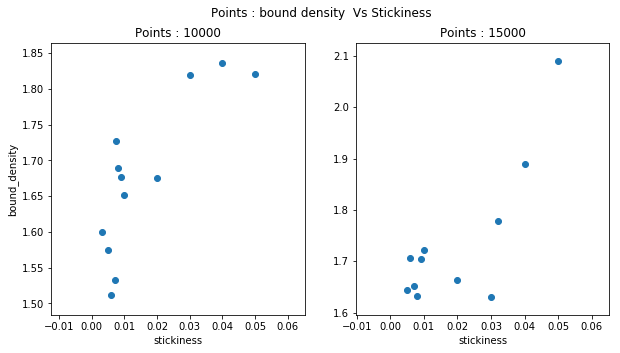

In [24]:
plt.rcParams['figure.figsize'] = 10, 5
points = [10000, 15000]
fig, axs = plt.subplots(1, 2, sharey=False, squeeze=True)
fig.suptitle("Points : bound density  Vs Stickiness")
axs[0].set_ylabel("bound_density")
for i,n in enumerate(points):
    df1=dff1.loc[dff1["Points"]==n,:]
    ax1=axs[i].scatter(np.array(df1['stickiness']), np.array(df1['bound_density']))
    axs[i].set_title("Points : "+str(n))
    axs[i].set_xlabel('stickiness')
plt.show()

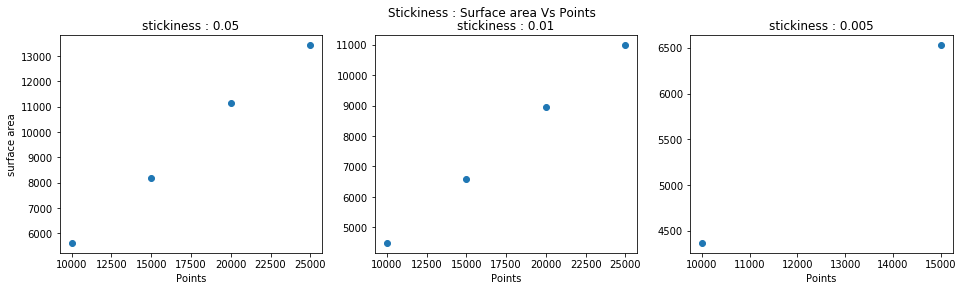

In [25]:
plt.rcParams['figure.figsize'] = 16, 4
k_values = [0.05, 0.01, 0.005]
fig, axs = plt.subplots(1, 3, sharey=False, squeeze=True)
fig.suptitle("Stickiness : Surface area Vs Points")
axs[0].set_ylabel('surface area')
for i,k in enumerate(k_values):
    df1=dff1.loc[dff1["stickiness"]==k,:]
    ax1=axs[i].scatter(np.array(df1['Points']), np.array(df1['surface_area']))
    axs[i].set_title("stickiness : "+str(k))
    axs[i].set_xlabel('Points')
    #axs.suptitle('Points : '+str(n))
plt.show()

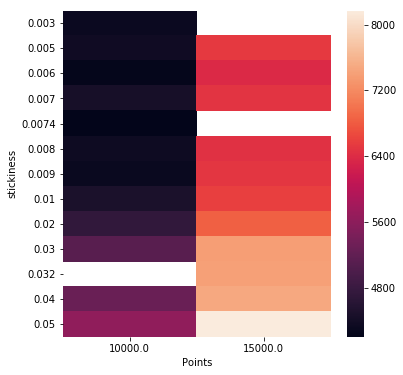

In [26]:
df1=dff1.loc[dff1['Points'].isin([10000,15000]),:]
df1=df1.pivot("stickiness", "Points", "surface_area")
plt.rcParams['figure.figsize'] = 6, 6
ax=sns.heatmap(df1)

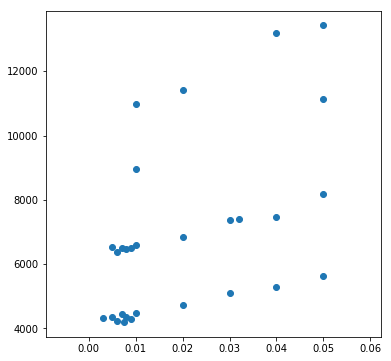

In [27]:
plt.scatter(dff1['stickiness'], dff1['surface_area'])

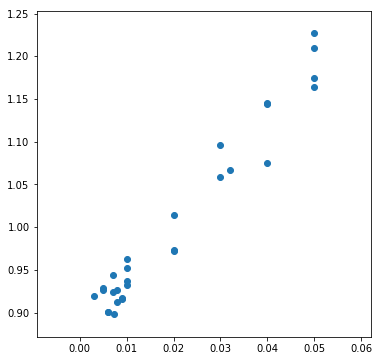

In [28]:
plt.scatter(dff1['stickiness'], dff1['ND/N'])

In [29]:
# As per stickness vs S/N plot show k is polynomial fit to surface area for given number of points
x=np.array(dff1['S/N'])
y=np.array(dff1['stickiness'])
pred1_obj_sa = np.poly1d(np.polyfit(x, y, 3))
s=list(map(lambda i: pred1_obj_sa(i), list(x)))

# validation on same data set
print("Mean Absolute % Error for Polynomial Fit : ")
print(np.absolute(np.divide(y-np.array(s), y)).sum()/len(s))

Mean Absolute % Error for Polynomial Fit : 
0.22217092185833648


In [30]:
dff1.sort_values(['stickiness'])

,Array_length,Points,bound_density,neighborhood_density,surface_area,stickiness,S/N,ND/N,ratio
18,501.0,10000.0,1.600200,9198.0,4320.0,0.0030,0.432000,0.919800,0.212578
58,501.0,10000.0,1.575000,9290.0,4366.0,0.0050,0.436600,0.929000,0.217041
34,501.0,15000.0,1.643200,13896.0,6528.0,0.0050,0.435200,0.926400,0.209392
57,501.0,10000.0,1.512500,9004.0,4238.0,0.0060,0.423800,0.900400,0.218871
17,501.0,15000.0,1.706400,13506.0,6374.0,0.0060,0.424933,0.900400,0.199374
21,501.0,10000.0,1.532700,9442.0,4436.0,0.0070,0.443600,0.944200,0.224460
66,501.0,15000.0,1.650933,13854.0,6494.0,0.0070,0.432933,0.923600,0.207755
64,501.0,10000.0,1.727200,8982.0,4202.0,0.0074,0.420200,0.898200,0.195678
23,501.0,10000.0,1.689100,9260.0,4356.0,0.0080,0.435600,0.926000,0.205017
36,501.0,15000.0,1.632800,13686.0,6458.0,0.0080,0.430533,0.912400,0.208659


In [31]:
# linear fit for the data
x = np.array(dff1[['bound_density','S/N']])
y=np.array(dff1['stickiness'])

reg = linear_model.LinearRegression().fit(x, y)
reg.score(x,y)

0.9643645045181699

In [32]:
df_test = dff_test.loc[dff_test['stickiness']<=0.05,:]
df_test['S/N']=df_test['surface_area']/df_test['Points']
df_test['ND/N']=df_test['neighborhood_density']/df_test['Points']
x_test_sa=np.array(df_test['S/N'])
x_test_nd=np.array(df_test['ND/N'])
y=np.array(df_test['stickiness'])
k_sa = list(map(lambda i: pred1_obj_sa(i), list(x_test_sa)))
print("MSE for Polynomial Fit using Surface Area: ")
print(np.square(y-np.array(k_sa)).sum()/len(df_test))
k_reg = reg.predict(df_test[['bound_density','S/N']])
print("MSE for Reg model Fit using bounding density, Surface Area: ")
print(np.square(y-np.array(k_reg)).sum()/len(df_test))

MSE for Polynomial Fit using Surface Area: 
2.6727128379406274e-05
MSE for Reg model Fit using bounding density, Surface Area: 
1.895379179730398e-05


In [33]:
df_test

,Array_length,Points,bound_density,neighborhood_density,surface_area,stickiness,S/N,ND/N
4,501.0,9239.0,1.650179,10102.0,4726.0,0.0296,0.511527,1.093408
5,501.0,15820.0,1.689760,14578.0,6868.0,0.0115,0.434134,0.921492
7,501.0,13348.0,1.618595,12626.0,5902.0,0.0183,0.442164,0.945909
8,501.0,15660.0,1.716475,16778.0,7826.0,0.0292,0.499745,1.071392
9,501.0,18057.0,2.270255,21422.0,9894.0,0.0451,0.547932,1.186354
10,501.0,5700.0,1.805263,6786.0,3144.0,0.0442,0.551579,1.190526
14,501.0,11399.0,1.622248,10490.0,4936.0,0.0098,0.433020,0.920256
15,501.0,8345.0,1.681965,7740.0,3634.0,0.0045,0.435470,0.927501
